In [2]:
import torch
import numpy as np
import sys

sys.path.append('../human_body_prior/tools/')
from omni_tools import copy2cpu as c2c
from os import path as osp

both57m_dir = '../data/both57m/'
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(comp_device)

sys.path.append('../human_body_prior/body_model/')
from body_model import BodyModel

gender = "male"

bm_fname = '../smplh_models/{}/model.npz'.format(gender)
bm = BodyModel(bm_fname=bm_fname).to(comp_device)
faces = c2c(bm.f)

cuda


In [3]:
data_number = 500

both57m_npz = osp.join(both57m_dir, str(data_number), 'data.npz')
bdata = np.load(both57m_npz)
len = bdata['seq_len']

motion_parms = {
    'root_orient': torch.Tensor(bdata['root_orient']).to(comp_device),
    'pose_body': torch.Tensor(bdata['body_pose'].reshape(len,-1)).to(comp_device),
    'pose_hand': torch.Tensor(bdata['hand_pose'].reshape(len,-1)).to(comp_device),
    'trans': torch.Tensor(bdata['trans']).to(comp_device)
}

body_pose = bm(**{k:v for k,v in motion_parms.items() if k in ['pose_body', 'pose_hand', 'root_orient']})
joints = np.zeros((len, 52, 3))

for i in range(len):
    array = c2c(body_pose.Jtr[i])
    array = array[:,[2,0,1]]
    array -= array[0,:]
    array += np.array([0,0,0.956])
    joints[i] = array

print(type(joints), joints.shape)

del body_pose

<class 'numpy.ndarray'> (150, 52, 3)


In [4]:
# import trimesh
# import mediapy as media

# sys.path.append('../body_visualizer')
# from mesh.mesh_viewer import MeshViewer
# from tools.vis_tools import colors, show_image

# imw, imh=1600, 1600
# mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

# body_pose = bm(**{k:v for k,v in motion_parms.items() if k in ['pose_body', 'pose_hand', 'root_orient']})

# body_images = []
# for i in range(len):
#     body_mesh = trimesh.Trimesh(vertices=c2c(body_pose.v[i]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
#     mv.set_static_meshes([body_mesh])
#     body_image = mv.render(render_wireframe=False)
#     body_images.append(body_image)

# media.show_video(images=body_images,fps=int(bdata['framerate']),width=700)

In [12]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2R,get_idxs
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

xml_path = '../asset/smplh_rig/scene_smplh_rig.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]

SMPLH_BODY_NAMES = ['pelvis','left_hip','right_hip','spine1','left_knee',
    'right_knee','spine2','left_ankle','right_ankle','spine3','left_foot',
    'right_foot','neck','left_collar','right_collar','head',
    'left_shoulder','right_shoulder','left_elbow','right_elbow','left_wrist','right_wrist']
    
SMPLH_HAND_NAMES = ['left_index1', 'left_index2','left_index3',
    'left_middle1','left_middle2','left_middle3',
    'left_pinky1','left_pinky2','left_pinky3',
    'left_ring1','left_ring2','left_ring3',
    'left_thumb1','left_thumb2','left_thumb3',
    'right_index1','right_index2','right_index3',
    'right_middle1','right_middle2','right_middle3',
    'right_pinky1','right_pinky2','right_pinky3',
    'right_ring1','right_ring2','right_ring3',
    'right_thumb1','right_thumb2','right_thumb3']

frame_number = 0

p_target = {}
for (i,n) in enumerate(SMPLH_BODY_NAMES + SMPLH_HAND_NAMES):
    p_target[n] = joints[frame_number,i,:]

MuJoCo version:[3.1.2]
dt:[0.0020] HZ:[500]
n_dof (=nv):[89]
n_geom:[73]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'pelvis2spine1', 'spine12spine2', 'spine22spine3', 'spine32neck', 'spine32lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex0', 'lwrist2lmiddle0', 'lwrist2lpinky0', 'lwrist2lring0', 'lwrist2lthumb1', 'lindex0-lindex1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle0-lmiddle1', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lpinky0-lpinky1', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lring0-lring1', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex0', 'rwrist2rmiddle0', 'rwrist2rpinky0', 'rwrist2rring0', 'rwrist2rthumb1', 'rindex0-rindex1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rind

Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.


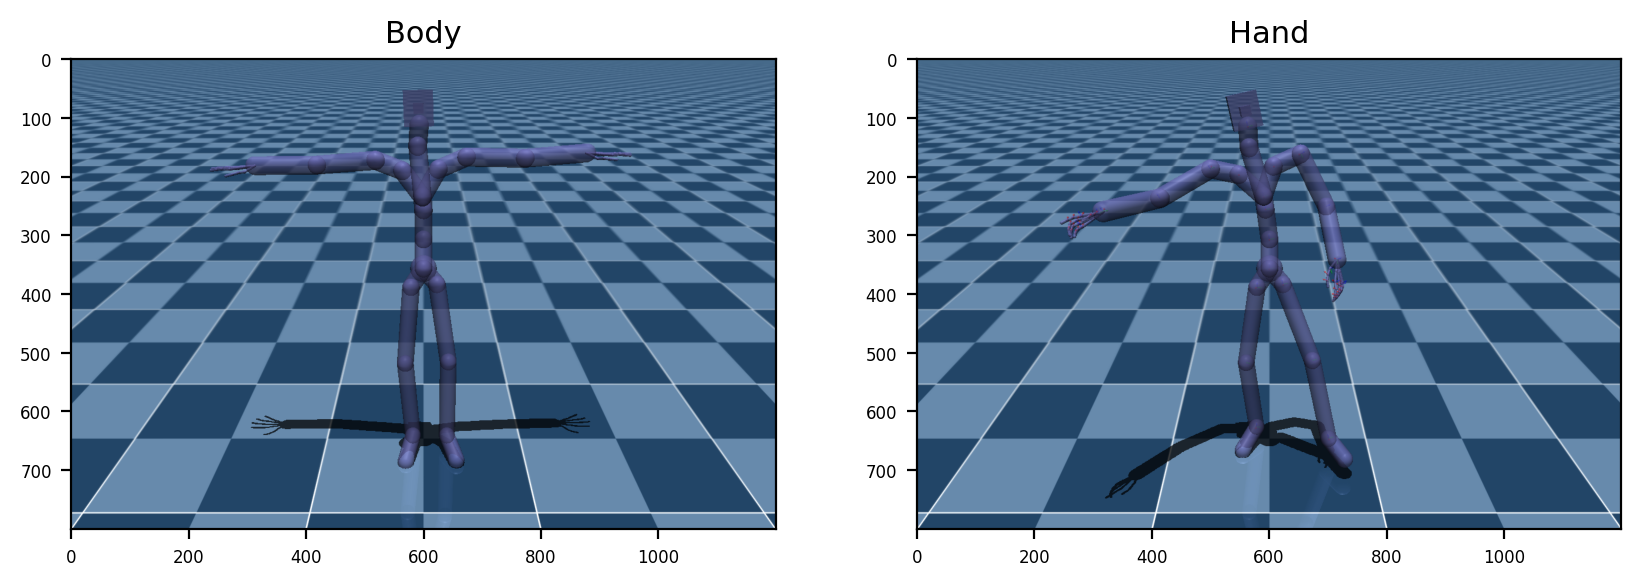

In [15]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common-Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=2.6,elevation=-25,lookat=[0.0,0.0,0.83])
env.reset()

BODY_JOINT_NAMES = ['pelvis1', 'pelvis2', 'pelvis3', 'spine1x', 'spine1y', 'spine1z', 
                    'spine2x', 'spine2y', 'spine2z', 'spine3x', 'spine3y', 'spine3z','head1', 'head2', 'head3', 
                    'l_collar', 'l_shoulder1', 'l_shoulder2', 'l_shoulder3', 'l_elbow', 'l_wrist1', 'l_wrist2', 'l_wrist3', 
                    'r_collar', 'r_shoulder1', 'r_shoulder2', 'r_shoulder3', 'r_elbow', 'r_wrist1', 'r_wrist2', 'r_wrist3', 
                    'l_hip1', 'l_hip2', 'l_hip3', 'l_knee', 'l_ankle1', 'l_ankle2', 'l_ankle3', 
                    'r_hip1', 'r_hip2', 'r_hip3', 'r_knee', 'r_ankle1', 'r_ankle2', 'r_ankle3']

idxs = get_idxs(env.rev_joint_names,BODY_JOINT_NAMES)
q_mins_upper_body,q_maxs_upper_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
joint_idxs_fwd_upper_body = env.get_idxs_fwd(joint_names=BODY_JOINT_NAMES)
joint_idxs_jac_upper_body = env.get_idxs_jac(joint_names=BODY_JOINT_NAMES)

HAND_JOINT_NAMES = ['l_indexr', 'l_index1', 'l_index2', 'l_index3', 'l_middle1', 'l_middle2', 'l_middle3', 
                    'l_pinkyr', 'l_pinky1', 'l_pinky2', 'l_pinky3', 'l_ringr', 'l_ring1', 'l_ring2', 'l_ring3', 
                    'l_thumbr', 'l_thumba', 'l_thumb2', 'l_thumb3', 
                    'r_indexr', 'r_index1', 'r_index2', 'r_index3', 'r_middle1', 'r_middle2', 'r_middle3', 
                    'r_pinkyr', 'r_pinky1', 'r_pinky2', 'r_pinky3', 'r_ringr', 'r_ring1', 'r_ring2', 'r_ring3', 
                    'r_thumbr', 'r_thumba', 'r_thumb2', 'r_thumb3', ]

idxs = get_idxs(env.rev_joint_names,HAND_JOINT_NAMES)
q_mins_hand,q_maxs_hand = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
joint_idxs_fwd_hand = env.get_idxs_fwd(joint_names=HAND_JOINT_NAMES)
joint_idxs_jac_hand = env.get_idxs_jac(joint_names=HAND_JOINT_NAMES)


FIRST_FLAG = True

while env.is_viewer_alive():

    UPDATE_RIG_BASE = True
    if UPDATE_RIG_BASE:
        p_base = p_target['pelvis']
        R_base = rpy2R(bdata['root_orient'][frame_number,[2,0,1]],[0,1,2])
        env.set_p_root(root_name='base',p=p_base)
        env.set_R_root(root_name='base',R=R_base)
        env.forward()

    q_body = env.get_qpos_joints(BODY_JOINT_NAMES)
    for ik_tick in range(100):
        J_list,ik_err_list = [],[]
        for ik_body_name in SMPLH_BODY_NAMES:
            ik_p_trgt = p_target[ik_body_name]
            ik_R_trgt = None
            IK_P = True
            IK_R = False
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q_body = q_body + dq[joint_idxs_jac_body]

        q_body = np.clip(q_body,q_mins_body,q_maxs_body)
        env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_body = env.grab_image()
        
    q_hand = env.get_qpos_joints(HAND_JOINT_NAMES)
    for ik_tick in range(100): # ik loop
        J_list,ik_err_list = [],[]
        for ik_hand_name in SMPLH_HAND_NAMES:
            ik_p_trgt = p_target[ik_hand_name]
            ik_R_trgt = None
            IK_P = True
            IK_R = False
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_hand_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q_hand = q_hand + dq[joint_idxs_jac_hand] # update

        q_hand = np.clip(q_hand,q_mins_hand,q_maxs_hand)
        env.forward(q=q_hand,joint_idxs=joint_idxs_fwd_hand)

        coupled_joint_idxs_list = [[47,48],[31,32,33],[34,35,36],[42,43,44],[38,39,40],[41,37],
                                   [74,75],[58,59,60],[61,62,63],[65,66,67],[69,70,71],[68,64]]

        coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5],
                                      [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],[2,5]]
        
        q_couple = env.get_q_couple(
            q_raw=env.data.qpos,
            coupled_joint_idxs_list=coupled_joint_idxs_list,
            coupled_joint_weights_list=coupled_joint_weights_list)
        q_hand = q_couple[joint_idxs_fwd_hand]
        q_hand = np.clip(q_hand,q_mins_hand,q_maxs_hand)
        env.forward(q=q_hand,joint_idxs=joint_idxs_fwd_hand)

    if env.loop_every(tick_every=10):
        for i in range(52):
            env.plot_T(p=joints[frame_number,i,:],R=np.eye(3),
                        PLOT_AXIS=True,axis_len=0.03,axis_width=0.0006)
    
    env.render()

    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_hand = env.grab_image()
        
env.close_viewer()

ig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_body)
axs[0].set_title('Body',fontsize=11)
axs[1].imshow(scene_img_hand)
axs[1].set_title('Hand',fontsize=11)
plt.show()